# Subgroup Robustness Grows on Trees (Trees - Adult)
In this notebook, we (empirically) investigate the different trees produced by three tree ensemble methods and evaluate
their *individual* performance on groups in the data. In particular, we investigate the trees constructed by:
1. Random Forests
2. Gradient-boosted Trees (`sklearn`)
3. Gradient-boosted Trees (`XGBoost`)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle
import time

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

## Datasets Overview
We'll run experiments on four datasets typically used in the fairness and robustness literature:

1. ACS Income (*large*). $n = 499,350$ examples, $20$ features, sensitive groups: *Race* and *Sex*.
2. ACS Employment (*large*). $n = 376,035$ examples, $17$ features, sensitive groups: *Race* and *Sex*. 
3. Adult (*medium*) $n = 48,845$ examples, $14$ features, sensitive groups: *Race* and *Sex*.
4. Communities and Crime (*small*) $n = 1,994$ examples, $113$ features, sensitive groups: *Income Level* and *Race.*

We also plan to do experiments with a fifth synthetic dataset that has overlapping group structure.

# Adult Dataset (Overlapping Groups)
The Adult Dataset is a benchmark derived from 1994 US Census data. The task is to predict whether an individual's income
exceeds $50,000 (binary classification). Sensitive attributes are *Race* and *Sex*.

- *Race:* $\{\text{White}, \text{Asian-Pac-Islander}, \text{Amer-Indian-Eskimo}, \text{Other}, \text{Black} \}$
- *Sex:* $\{\text{Male}, \text{Female}\}$

The standard in the literature has been to simplify the groups for *Race* to $\text{White}$ and $\text{NotWhite}$.

## Preprocess and Clean Adult
The Adult dataset is a binary classification task with *categorical* and *numerical* features. We binarize the categorical
features with `OneHotEncoder` and normalize the numerical features with `MinMaxScaler`. We also drop all the rows with missing
features, leaving us with $n = 45,222$ examples total.

In [7]:
# Adult Dataset
adult_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                "marital-status", "occupation", "relationship", "race", "sex",
                "capital-gain", "capital-loss", "hours-per-week", "native-country", 
                "income"]
adult_data = pd.read_csv("./datasets/adult/adult.data", header=None, names=adult_names, na_values=' ?')
adult_data = adult_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
adult_test = pd.read_csv("./datasets/adult/adult.test", header=None, names=adult_names, na_values=' ?')
adult_test = adult_test.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
dfs = [adult_data, adult_test]
adult_df = pd.concat(dfs)
adult_df = adult_df.dropna()
adult_df = adult_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
print("Adult Shape: {}".format(adult_df.shape))

# last column in adult has some textual discrepancy
adult_df = adult_df.replace(">50K.", ">50K")
adult_df = adult_df.replace("<=50K.", "<=50K")

# Split into X and y
X, y = adult_df.drop("income", axis=1), adult_df["income"]

# Select categorical and numerical features
cat_idx = X.select_dtypes(include=["object", "bool"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variable so we have classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples >=50k (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples <50k (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

Adult Shape: (45222, 15)
% examples >=50k (y=1): 24.78439697492371
% examples <50k (y=0): 75.21560302507629


Traditionally, there are $|\mathcal{G}| = 4$ groups in Adult: *(White, Male), (NotWhite, Male), (White, Female),* and *(NotWhite, Female)*.

In this notebook, we will instead do the following group structure for Adult:
- Overlapping groups (make *White* and *NotWhite* their own groups, make *Male* and *Female* their own groups).


In [8]:
def adult_gp_indices(df, race_val, sex_val):
    if race_val == "NotWhite":
        return np.where((df['race'] != 'White') & (df['sex'] == sex_val))
    else:
        return np.where((df['race'] == race_val) & (df['sex'] == sex_val))

group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
race_gps_coarse = ["White", "NotWhite"]
sex_gps = ["Male", "Female"]

# Traditional disjoint groups
for race in race_gps_coarse:
    for sex in sex_gps:
        indices = adult_gp_indices(X, race, sex)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
w_indices = np.where(X['race'] == 'White')
w_membership = np.zeros(y.shape[0], dtype=bool)
w_membership[w_indices] = True
group_memberships.append(w_membership)

nw_indices = np.where(X['race'] != 'White')
nw_membership = np.zeros(y.shape[0], dtype=bool)
nw_membership[nw_indices] = True
group_memberships.append(nw_membership)

m_indices = np.where(X['sex'] == 'Male')
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['sex'] == 'Female')
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [9]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (45222, 104)


In [10]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			36177	9045
1 (W,M)			21603	5417
2 (W,F)			9520	2363
3 (nW,M)			2815	692
4 (nW,F)			2239	573
5 (W)			31123	7780
6 (nW)			5054	1265
7 (M)			24418	6109
8 (F)			11759	2936


In [11]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.24378109452736318
P(Y=1 | group 1) = 0.31733431788812994
P(Y=1 | group 2) = 0.12018620397799408
P(Y=1 | group 3) = 0.22687861271676302
P(Y=1 | group 4) = 0.07853403141361257
P(Y=1 | group 5) = 0.25745501285347044
P(Y=1 | group 6) = 0.15968379446640316
P(Y=1 | group 7) = 0.307087903093796
P(Y=1 | group 8) = 0.11205722070844687


# Utility Code for Parameter Searching
Just some code to make things easier.

In [12]:
# Utilities for fitting  and evaluating models
from sklearn.model_selection import cross_val_predict, GridSearchCV
from joblib import Parallel, delayed

'''
Function for training a model ERM on some KFold splits and then evaluating on
each group for each of the splits.
'''
def split_and_eval(X, y, model, transformer, group_memberships, num_groups, train_size):
    splits = train_test_split(*tuple([X, y] + group_memberships), train_size=train_size)
    X_train = splits[0]
    X_test = splits[1]
    y_train = splits[2]
    y_test = splits[3]

    group_train = splits[4::2]
    group_test = splits[5::2]
    model.fit(transformer.transform(X_train), y_train)

    # Evaluate on all groups
    yhats = {}
    test_errs = {}
    for g in range(num_groups):
        yhats[g] = model.predict(transformer.transform(X_test))
        test_errs[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])        
    
    return yhats, test_errs

def paralell_split_eval(X, y, model, transformer, group_memberships, num_groups, train_size, n_splits, n_jobs=-1):
    parallel = Parallel(n_jobs=n_jobs)
    results = parallel(
        delayed(split_and_eval)(X, y, model, transformer, group_memberships, 
                                num_groups, train_size
        )
        for split in range(n_splits)
    )

    mean_test_errs = {}
    std_errs = {}
    for g in range(num_groups):
        test_errs_g = [test_errs[g] for _, test_errs in results]
        mean_test_errs[g] = np.mean(test_errs_g)
        std_errs[g] = np.sqrt( np.var(test_errs_g) ) / n_splits

    return mean_test_errs, std_errs

# Fit Random Forests
First, we fit `sklearn` Random Forests to the dataset, over a hyperparameter sweep on following parameters:
1. `n_estimators`: the number of trees total in the forest.
2. `max_depth`: the maximum depth of the tree, an `int`. 
3. `min_samples_split`: the minimum number of samples required to split at an internal node. if the number of samples at a node is *less than* `min_samples_split`, we
that node becomes a leaf node.
4. `ccp_alpha`: the complexity parameter used in Minimal Cost-Complexity Pruning. for nonzero values, pruning is performed.

The parameter sweep is linear (unparallelized); the cross-validation is parallelized.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

In [27]:
# Hyperparameter sweep for RF
n_estimators_params = [8, 16, 32, 64, 128, 256]
grid = {
    'max_depth': [2, 4, 8, 16, None],
    'ccp_alpha': [0., 0.001, 0.01, 0.1],
    'random_state': [0]
}

param_grid = list(ParameterGrid(grid))
print("Fitting {} models total...".format(len(param_grid) * len(n_estimators_params)))
best_rf_params_avg = {}
best_rf_params_worstgp = {}
for n_estimators in n_estimators_params:
    best_avg_err = np.Inf
    best_worstgp_err = np.Inf
    for params in param_grid:
        params['n_estimators'] = n_estimators
        rf_model = RandomForestClassifier(**params)
        start = time.time()
        mean_test_errs, _ = paralell_split_eval(X, y, rf_model, col_transf, group_memberships, num_groups, train_size=0.8, n_splits=5, n_jobs=5)
        end = time.time()
        print("Cross-validated RandomForestClassifier ({}) in {} seconds.".format(params, end - start))

        avg_err = mean_test_errs[0]
        worstgp_err = max(mean_test_errs.values())
        print("\tAverage Error: {}".format(avg_err))
        print("\tWorst-group Error: {}".format(worstgp_err))

        if avg_err < best_avg_err:
            best_avg_err = avg_err
            best_rf_params_avg[n_estimators] = params.copy()
        if worstgp_err < best_worstgp_err:
            best_worstgp_err = worstgp_err
            best_rf_params_worstgp[n_estimators] = params.copy()

Fitting 120 models total...
Cross-validated RandomForestClassifier ({'ccp_alpha': 0.0, 'max_depth': 2, 'random_state': 0, 'n_estimators': 8}) in 0.7825958728790283 seconds.
	Average Error: 0.22489773355444997
	Worst-group Error: 0.28879332802929614
Cross-validated RandomForestClassifier ({'ccp_alpha': 0.0, 'max_depth': 4, 'random_state': 0, 'n_estimators': 8}) in 0.8738727569580078 seconds.
	Average Error: 0.17965726920950803
	Worst-group Error: 0.22662887649455482
Cross-validated RandomForestClassifier ({'ccp_alpha': 0.0, 'max_depth': 8, 'random_state': 0, 'n_estimators': 8}) in 0.8506050109863281 seconds.
	Average Error: 0.15268103924820342
	Worst-group Error: 0.19388348373762096
Cross-validated RandomForestClassifier ({'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 8}) in 1.113358974456787 seconds.
	Average Error: 0.14350469872857935
	Worst-group Error: 0.18170991222446262
Cross-validated RandomForestClassifier ({'ccp_alpha': 0.0, 'max_depth': None, 'random_st

In [31]:
print(best_rf_params_avg)
print(best_rf_params_worstgp)

{8: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 8}, 16: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 16}, 32: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 32}, 64: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 64}, 128: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 128}, 256: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 256}}
{8: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 8}, 16: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 16}, 32: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 32}, 64: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 64}, 128: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 128}, 256: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 256}}


In [30]:
# Refit the best estimators (worst-group and average accuracy)
best_rfs_avg = {}
best_rfs_worstgp = {}

for n_estimators in n_estimators_params:
    rf_model_avg = RandomForestClassifier(**best_rf_params_avg[n_estimators])
    rf_model_avg.fit(col_transf.transform(X_train), y_train)
    rf_model_worstgp = RandomForestClassifier(**best_rf_params_worstgp[n_estimators])
    rf_model_worstgp.fit(col_transf.transform(X_train), y_train)

    print("n_estimators: {}".format(n_estimators))
    print("\tAverage accuracy (RF-avg, {} estimators): {}".format(n_estimators, accuracy_score(rf_model_avg.predict(col_transf.transform(X_test)), y_test)))
    yhats = rf_model_avg.predict(col_transf.transform(X_test))
    worstgp_err = np.mean(y_test[group_test[1]] != yhats[group_test[1]])    
    print("\tWorst-group accuracy (RF-avg, {} estimators): {}".format(n_estimators, 1 - worstgp_err))

    print("\tAverage accuracy (RF-worstgp, {} estimators): {}".format(n_estimators, accuracy_score(rf_model_worstgp.predict(col_transf.transform(X_test)), y_test)))
    yhats = rf_model_worstgp.predict(col_transf.transform(X_test))
    worstgp_err = np.mean(y_test[group_test[1]] != yhats[group_test[1]])    
    print("\tWorst-group accuracy (RF-worstgp, {} estimators): {}".format(n_estimators, 1 - worstgp_err))

    best_rfs_avg[n_estimators] = rf_model_avg
    best_rfs_worstgp[n_estimators] = rf_model_worstgp

n_estimators: 8
	Average accuracy (RF-avg, 8 estimators): 0.8572692095080154
	Worst-group accuracy (RF-avg, 8 estimators): 0.8150267675835333
	Average accuracy (RF-worstgp, 8 estimators): 0.8572692095080154
	Worst-group accuracy (RF-worstgp, 8 estimators): 0.8150267675835333
n_estimators: 16
	Average accuracy (RF-avg, 16 estimators): 0.8568269762299613
	Worst-group accuracy (RF-avg, 16 estimators): 0.8141037474616947
	Average accuracy (RF-worstgp, 16 estimators): 0.8568269762299613
	Worst-group accuracy (RF-worstgp, 16 estimators): 0.8141037474616947
n_estimators: 32
	Average accuracy (RF-avg, 32 estimators): 0.858595909342178
	Worst-group accuracy (RF-avg, 32 estimators): 0.8157651836810043
	Average accuracy (RF-worstgp, 32 estimators): 0.858595909342178
	Worst-group accuracy (RF-worstgp, 32 estimators): 0.8157651836810043
n_estimators: 64
	Average accuracy (RF-avg, 64 estimators): 0.8589275843007186
	Worst-group accuracy (RF-avg, 64 estimators): 0.8163189957541075
	Average accuracy (

In [32]:
# Pick apart the estimator to get the individual tree models
n_estimators = 8
rf_model = best_rfs_avg[n_estimators]
rf_trees = list(rf_model.estimators_)
print("{} individual decision trees in forest.".format(len(rf_trees)))

8 individual decision trees in forest.


In [49]:
# For each group, evaluate tree models on the group:
# - variance per group
# - tree model that's best for the group
rf_test_errs = {}                       # n_estimators: test errors per group
rf_test_vars = {}
rf_test_ranges = {}
rf_test_mins = {}
for n_estimators in n_estimators_params:
    test_errs = {}
    rf_model = best_rfs_worstgp[n_estimators]
    rf_trees = list(rf_model.estimators_)
    rf_test_vars[n_estimators] = {}
    rf_test_ranges[n_estimators] = {}
    rf_test_mins[n_estimators] = {}
    for g in range(num_groups):
        test_errs[g] = []
        for tree in rf_trees:
            yhats = tree.predict(col_transf.transform(X_test))
            test_errs[g].append(np.mean(y_test[group_test[g]] != yhats[group_test[g]]))
        rf_test_vars[n_estimators][g] = np.var(test_errs[g])
        rf_test_ranges[n_estimators][g] = np.max(test_errs[g]) - np.min(test_errs[g])
        rf_test_mins[n_estimators][g] = np.min(test_errs[g])

    rf_test_errs[n_estimators] = test_errs

In [48]:
rf_test_mins

{8: 0.08344686648501362,
 16: 0.08106267029972752,
 32: 0.08106267029972752,
 64: 0.07799727520435967,
 128: 0.07493188010899182,
 256: 0.07425068119891008}

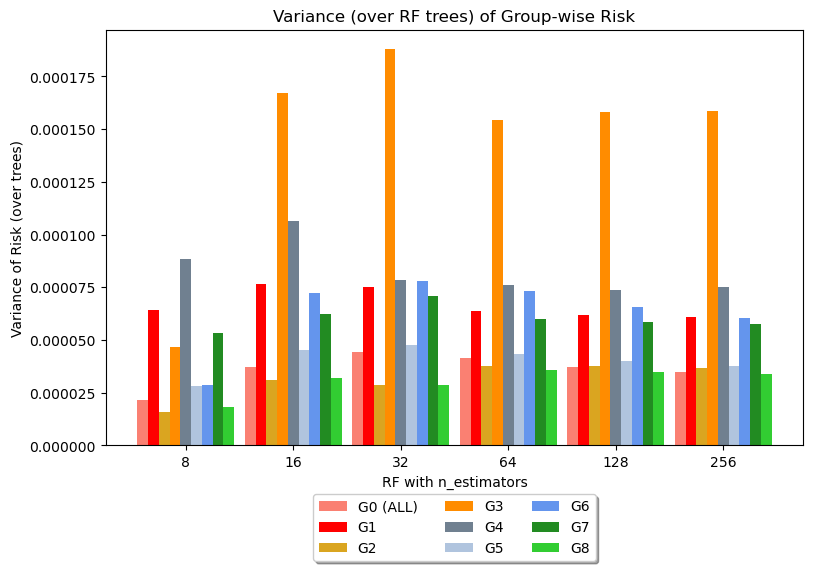

In [61]:
# Plot the variances (for each group, across all trees) for each of the RF models
# Compute the variances
plot_group_labels = n_estimators_params
plot_x = np.arange(len(n_estimators_params))
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 4.0*bar_width, [rf_test_vars[n_estimators][0] for n_estimators in n_estimators_params], bar_width, label='G0 (ALL)', color="salmon")
plot_rects2 = ax.bar(plot_x - 3.0*bar_width, [rf_test_vars[n_estimators][1] for n_estimators in n_estimators_params], bar_width, label='G1', color="red")
plot_rects3 = ax.bar(plot_x - 2.0*bar_width, [rf_test_vars[n_estimators][2] for n_estimators in n_estimators_params], bar_width, label='G2', color="goldenrod")
plot_rects4 = ax.bar(plot_x - 1.0*bar_width, [rf_test_vars[n_estimators][3] for n_estimators in n_estimators_params], bar_width, label='G3', color="darkorange")
plot_rects5 = ax.bar(plot_x - 0.0*bar_width, [rf_test_vars[n_estimators][4] for n_estimators in n_estimators_params], bar_width, label='G4', color="slategrey")
plot_rects6 = ax.bar(plot_x + 1.0*bar_width, [rf_test_vars[n_estimators][5] for n_estimators in n_estimators_params], bar_width, label='G5', color="lightsteelblue")
plot_rects7 = ax.bar(plot_x + 2.0*bar_width, [rf_test_vars[n_estimators][6] for n_estimators in n_estimators_params], bar_width, label='G6', color="cornflowerblue")
plot_rects8 = ax.bar(plot_x + 3.0*bar_width, [rf_test_vars[n_estimators][7] for n_estimators in n_estimators_params], bar_width, label='G7', color="forestgreen")
plot_rects9 = ax.bar(plot_x + 4.0*bar_width, [rf_test_vars[n_estimators][8] for n_estimators in n_estimators_params], bar_width, label='G8', color="limegreen")

ax.set_ylabel('Variance of Risk (over trees)')
ax.set_xlabel('RF with n_estimators')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Variance (over RF trees) of Group-wise Risk")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)

plt.show()

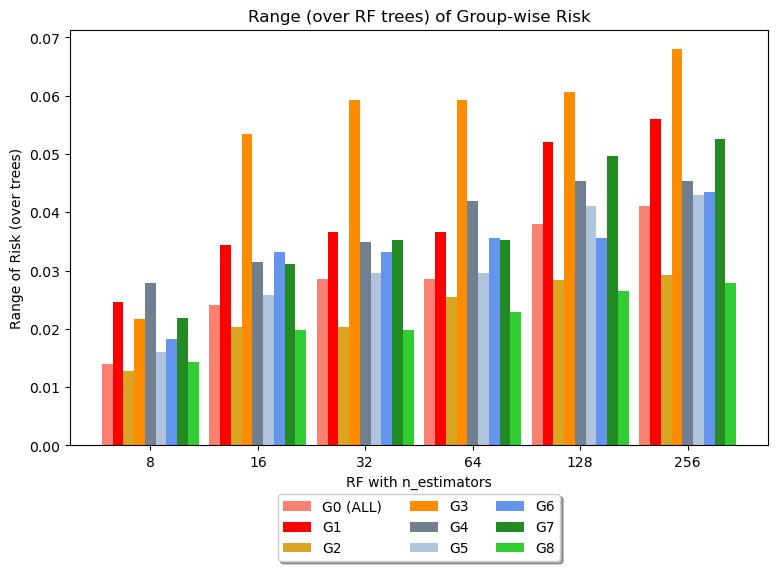

In [63]:
# Plot the ranges (for each group, across all trees) for each of the RF models
# Compute the variances
plot_group_labels = n_estimators_params
plot_x = np.arange(len(n_estimators_params))
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 4.0*bar_width, [rf_test_ranges[n_estimators][0] for n_estimators in n_estimators_params], bar_width, label='G0 (ALL)', color="salmon")
plot_rects2 = ax.bar(plot_x - 3.0*bar_width, [rf_test_ranges[n_estimators][1] for n_estimators in n_estimators_params], bar_width, label='G1', color="red")
plot_rects3 = ax.bar(plot_x - 2.0*bar_width, [rf_test_ranges[n_estimators][2] for n_estimators in n_estimators_params], bar_width, label='G2', color="goldenrod")
plot_rects4 = ax.bar(plot_x - 1.0*bar_width, [rf_test_ranges[n_estimators][3] for n_estimators in n_estimators_params], bar_width, label='G3', color="darkorange")
plot_rects5 = ax.bar(plot_x - 0.0*bar_width, [rf_test_ranges[n_estimators][4] for n_estimators in n_estimators_params], bar_width, label='G4', color="slategrey")
plot_rects6 = ax.bar(plot_x + 1.0*bar_width, [rf_test_ranges[n_estimators][5] for n_estimators in n_estimators_params], bar_width, label='G5', color="lightsteelblue")
plot_rects7 = ax.bar(plot_x + 2.0*bar_width, [rf_test_ranges[n_estimators][6] for n_estimators in n_estimators_params], bar_width, label='G6', color="cornflowerblue")
plot_rects8 = ax.bar(plot_x + 3.0*bar_width, [rf_test_ranges[n_estimators][7] for n_estimators in n_estimators_params], bar_width, label='G7', color="forestgreen")
plot_rects9 = ax.bar(plot_x + 4.0*bar_width, [rf_test_ranges[n_estimators][8] for n_estimators in n_estimators_params], bar_width, label='G8', color="limegreen")

ax.set_ylabel('Range of Risk (over trees)')
ax.set_xlabel('RF with n_estimators')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Range (over RF trees) of Group-wise Risk")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)

plt.show()

In [69]:
# Baseline Decision Tree with max_depth=16
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=16, random_state=0)
dtree.fit(col_transf.transform(X_train), y_train)
for g in range(num_groups):
    yhats = tree.predict(col_transf.transform(X_test))
    print("Decision Tree (max_depth=16, n_estimators=128) error for group {}: {}".format(g, np.mean(y_test[group_test[g]] != yhats[group_test[g]])))

Decision Tree (max_depth=16, n_estimators=128) error for group 0: 0.17600884466556108
Decision Tree (max_depth=16, n_estimators=128) error for group 1: 0.2182019568026583
Decision Tree (max_depth=16, n_estimators=128) error for group 2: 0.10198899703766398
Decision Tree (max_depth=16, n_estimators=128) error for group 3: 0.18352601156069365
Decision Tree (max_depth=16, n_estimators=128) error for group 4: 0.07329842931937172
Decision Tree (max_depth=16, n_estimators=128) error for group 5: 0.18290488431876606
Decision Tree (max_depth=16, n_estimators=128) error for group 6: 0.13359683794466404
Decision Tree (max_depth=16, n_estimators=128) error for group 7: 0.21427402193485023
Decision Tree (max_depth=16, n_estimators=128) error for group 8: 0.09638964577656675


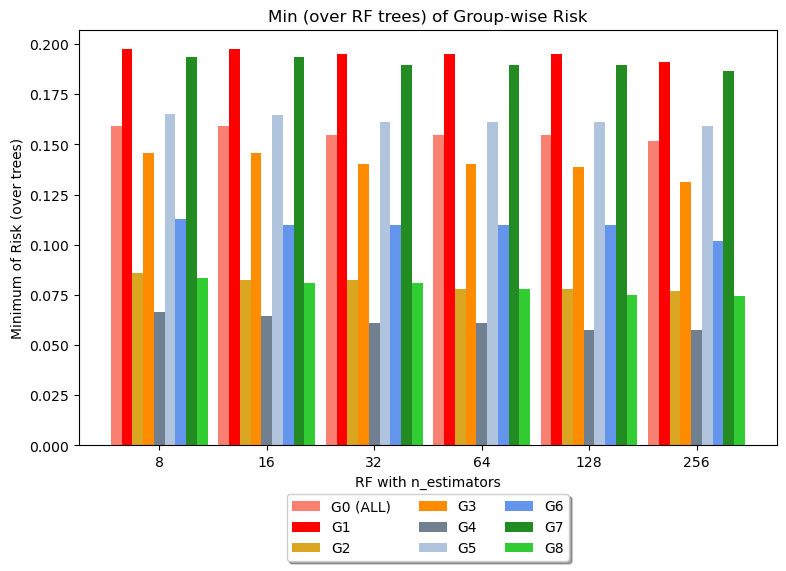

In [65]:
# Plot the min (for each group, across all trees) for each of the RF models
# Compute the variances
plot_group_labels = n_estimators_params
plot_x = np.arange(len(n_estimators_params))
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 4.0*bar_width, [rf_test_mins[n_estimators][0] for n_estimators in n_estimators_params], bar_width, label='G0 (ALL)', color="salmon")
plot_rects2 = ax.bar(plot_x - 3.0*bar_width, [rf_test_mins[n_estimators][1] for n_estimators in n_estimators_params], bar_width, label='G1', color="red")
plot_rects3 = ax.bar(plot_x - 2.0*bar_width, [rf_test_mins[n_estimators][2] for n_estimators in n_estimators_params], bar_width, label='G2', color="goldenrod")
plot_rects4 = ax.bar(plot_x - 1.0*bar_width, [rf_test_mins[n_estimators][3] for n_estimators in n_estimators_params], bar_width, label='G3', color="darkorange")
plot_rects5 = ax.bar(plot_x - 0.0*bar_width, [rf_test_mins[n_estimators][4] for n_estimators in n_estimators_params], bar_width, label='G4', color="slategrey")
plot_rects6 = ax.bar(plot_x + 1.0*bar_width, [rf_test_mins[n_estimators][5] for n_estimators in n_estimators_params], bar_width, label='G5', color="lightsteelblue")
plot_rects7 = ax.bar(plot_x + 2.0*bar_width, [rf_test_mins[n_estimators][6] for n_estimators in n_estimators_params], bar_width, label='G6', color="cornflowerblue")
plot_rects8 = ax.bar(plot_x + 3.0*bar_width, [rf_test_mins[n_estimators][7] for n_estimators in n_estimators_params], bar_width, label='G7', color="forestgreen")
plot_rects9 = ax.bar(plot_x + 4.0*bar_width, [rf_test_mins[n_estimators][8] for n_estimators in n_estimators_params], bar_width, label='G8', color="limegreen")

ax.set_ylabel('Minimum of Risk (over trees)')
ax.set_xlabel('RF with n_estimators')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Min (over RF trees) of Group-wise Risk")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Fit Gradient-Boosted Trees
Next, we fit `sklearn` Gradient-Boosted trees to the dataset, over a hyperparameter sweep on following parameters:
1. `n_estimators`: the number of trees total in the forest.
2. `max_depth`: the maximum depth of the tree, an `int`. 
3. `min_samples_split`: the minimum number of samples required to split at an internal node. if the number of samples at a node is *less than* `min_samples_split`, we
that node becomes a leaf node.
4. `ccp_alpha`: the complexity parameter used in Minimal Cost-Complexity Pruning. for nonzero values, pruning is performed.

The parameter sweep is linear (unparallelized); the cross-validation is parallelized.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

In [15]:
# Hyperparameter sweep for GBM
n_estimators_params = [8, 16, 32, 64, 128, 256, 512]
grid = {
    'max_depth': [2, 4, 8, 16],
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0],
    'random_state': [0]
}

param_grid = list(ParameterGrid(grid))
print("Fitting {} models total...".format(len(param_grid) * len(n_estimators_params)))
best_gb_params_avg = {}
best_gb_params_worstgp = {}
for n_estimators in n_estimators_params:
    best_avg_err = np.Inf
    best_worstgp_err = np.Inf
    for params in param_grid:
        params['n_estimators'] = n_estimators
        gb_model = GradientBoostingClassifier(**params)
        start = time.time()
        mean_test_errs, _ = paralell_split_eval(X, y, gb_model, col_transf, group_memberships, num_groups, train_size=0.8, n_splits=5, n_jobs=5)
        end = time.time()
        print("Cross-validated GradientBoostingClassifier ({}) in {} seconds.".format(params, end - start))

        avg_err = mean_test_errs[0]
        worstgp_err = max(mean_test_errs.values())
        print("\tAverage Error: {}".format(avg_err))
        print("\tWorst-group Error: {}".format(worstgp_err))

        if avg_err < best_avg_err:
            best_avg_err = avg_err
            best_gb_params_avg[n_estimators] = params.copy()
        if worstgp_err < best_worstgp_err:
            best_worstgp_err = worstgp_err
            best_gb_params_worstgp[n_estimators] = params.copy()

Fitting 140 models total...
Cross-validated GradientBoostingClassifier ({'learning_rate': 0.01, 'max_depth': 2, 'random_state': 0, 'n_estimators': 8}) in 1.9301650524139404 seconds.
	Average Error: 0.24705362078496407
	Worst-group Error: 0.32227287833078555
Cross-validated GradientBoostingClassifier ({'learning_rate': 0.01, 'max_depth': 4, 'random_state': 0, 'n_estimators': 8}) in 1.1413090229034424 seconds.
	Average Error: 0.24723051409618574
	Worst-group Error: 0.3226330836212482
Cross-validated GradientBoostingClassifier ({'learning_rate': 0.01, 'max_depth': 8, 'random_state': 0, 'n_estimators': 8}) in 1.7069809436798096 seconds.
	Average Error: 0.2502819237147595
	Worst-group Error: 0.3278547310478419
Cross-validated GradientBoostingClassifier ({'learning_rate': 0.01, 'max_depth': 16, 'random_state': 0, 'n_estimators': 8}) in 3.977712869644165 seconds.
	Average Error: 0.25105583195135434
	Worst-group Error: 0.32816098859048515
Cross-validated GradientBoostingClassifier ({'learning_

KeyboardInterrupt: 